Pre-processing of IF images

raw data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/ 

- To generate intensitity files for IgD, use input files 10015CN77_STB56_\*_IgD.jpg and 10015CN77_\*_annotations.txt
- To generate intensitity files for F480, use input files 10015CN77_STB56_\*_F480.jpg and 10015CN77_\*_annotations.txt
- To generate intensitity files for NeuN, use input files 10015CN78_STB56_\*_NeuN.jpg and 10015CN78_\*_annotations.txt

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage import morphology
from skimage.segmentation import watershed
from skimage import transform
Image.MAX_IMAGE_PIXELS = None

In [2]:
def remove_background_HE(img, threshold, connectivity, min_size):
    """
    Remove background and get black background in HE image.
    
    Returns a numpy array with removed background.
    """
    elevation_map = sobel(img)

    markers = np.zeros_like(elevation_map)
    markers[elevation_map < threshold] = 1  
    markers[elevation_map > threshold] = 2 

    segmentation = watershed(elevation_map, markers, connectivity=connectivity)
    
    cleaned = morphology.remove_small_objects(segmentation, min_size=min_size)

    return cleaned

def make_binary(mask_bgrm, original_image):
    """
    Make a new array of the HE with the background values in mask_bgrm (=1) set to 1.
    
    Returns a binary numpy array
    """

    mask = (mask_bgrm == 2)
    new_array = np.copy(mask_bgrm)
    new_array[mask] = original_image[mask]

    # Replace 1 with zero
    where_1 = np.where(new_array == 1)
    new_array[where_1] = 0
    
    return new_array

def resize(arr):
    """
    Resize image after ST well size.
    Returns x and y coordinates of the image fiited in a ST well, as well as the resized image. 
    """
    # Rescale
    image_rescaled = transform.resize(arr, (arr.shape[0] // 10, arr.shape[1] // 10), preserve_range=True,anti_aliasing=True) #, preserve_range=True

    xdim,ydim = image_rescaled.shape

    # WHy 32 and 34 SANJA!!
    testy = ydim/32-1
    testx = xdim/34-1

    x_indices = np.array([i*testy for i in range(1, 33)])
    y_indices = np.array([i*testx for i in range(1, 35)])

    x_coordinates = []
    y_coordinates = []
    for i in x_indices:
        for j in y_indices:
            x_coordinates.append(i)
            y_coordinates.append(j)

    return x_coordinates, y_coordinates, image_rescaled
            
def make_square_around_spot(ann, image_rescaled):
    """
    Makes a square around a ST spot by taking in ST coordinates. 
    Returns the df (ann) with x any max and min values of each spot.
    """
    # Make a square area of each spot
    xminmax = []
    for i in ann['new_x'].tolist():
        xminmax.append((float(i)-xdim/(image_rescaled.shape[0]/10),float(i)+xdim/(image_rescaled.shape[0]/10))) 

    yminmax = []
    for i in ann['new_y'].tolist():
        yminmax.append((float(i)-ydim/(image_rescaled.shape[0]/12),float(i)+ydim/(image_rescaled.shape[0]/12))) 

    df1 = pd.DataFrame(xminmax, columns = ['xmin', 'xmax'])
    df2 = pd.DataFrame(yminmax, columns = ['ymin', 'ymax'])

    results = pd.concat([ann, df1, df2], axis=1, sort=False )
    results[['xmin', 'xmax', 'ymin', 'ymax']] = results[['xmin', 'xmax', 'ymin', 'ymax']].astype(int)
    
    return results

def intensity_submatrix(row, img):
    """
    Calculates intensity of a submatrix based on x and y min and max values.
    Returns the sum intensity of the submatrix.
    
    """
    return img[row['ymin']:row['ymax'], row['xmin']:row['xmax']].sum()

In [187]:
# Files info
path = '../../smomics_data'

well = '10015CN87_E2'
batch = 'STB59'
prot = 'F480'
#well = well.split('_')[0] + well.split('_')[1]+ '_' + well.split('_')[2]
name = well.split('_')[0] + '_' + batch + '_' + well.split('_')[1]
#name = well.split('_')[0] +'_'+ well.split('_')[1]+'_' + batch + '_' + well.split('_')[2]

# .jpg
jpg_name =  os.path.join(path, name + '_' + prot + '.jpg')


# annotation
ann_file =  well + '_annotations.txt'

In [188]:
# Load jpg
he = rgb2gray(io.imread(jpg_name))

# Load mask
maskimg = np.array(he)
    

/Users/svickovi/miniconda3/envs/stenv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


In [189]:
# Remove backgorund of mask image
# thresholds morphology.watershed
## 0.009 (F480)
## 0.005 (IgD)
## 0.008 (NeuN)

threshold = 0.009 

mask_bgrm = remove_background_HE(maskimg, threshold, 1, 0)


In [190]:
# Make binary
new_HEarray = make_binary(mask_bgrm, he)


In [191]:
# find x, y coordinates in HE_new image
x_coordinates, y_coordinates, image_rescaled = resize(new_HEarray)

# To get xdim
xdim,ydim = image_rescaled.shape



In [192]:
# To get spots under tissue
#reads in the same annotation file as HE image
ann = pd.read_csv(os.path.join(path, ann_file), sep ="\t")

testy = ydim/32
testx = xdim/34

x_indices = np.array([(i-1)*testy for i in ann['x']])
y_indices = np.array([(i-1)*testx for i in ann['y']])

x_coordinates = []
y_coordinates = []
for i in x_indices:
    for j in y_indices:
        x_coordinates.append(i)
        y_coordinates.append(j) 

# add correct pixel coordiantes
ann['new_x'] = x_indices
ann['new_y'] = y_indices

# if ann label "Unknown" rename it to Background
ann['value'] = ann['value'].replace({'Unknown':'background'})

# rename regions to make sure they survive tf handling
new_names = [{x:x.lower().replace(" - "," ").replace(";"," and ")} for x in set(ann['value'])]
vals = [v for v in new_names for k,v in v.items()]
keys = [v for v in new_names for v,k in v.items()]
ann['value'] = ann['value'].replace({keys[i]: vals[i] for i in range(len(vals))})

# Make a circle area of each spot
results_round = make_square_around_spot(ann, image_rescaled)

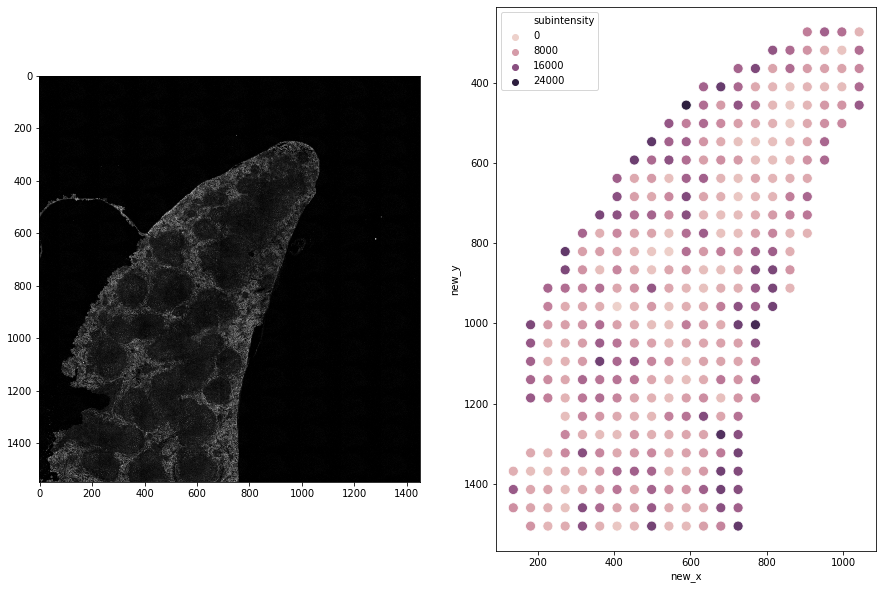

In [193]:
# Calculate intensity of subimages based on index values in submatrices in df
results_round['subintensity'] = results_round.apply(lambda row: intensity_submatrix(row, image_rescaled), axis=1)
results_round[['subintensity']] = results_round[['subintensity']].astype(int)

# initialize a figure
fig = plt.figure(figsize=(15, 10))

# for a 1x2 subplot
axes = []
for row_idx in range(0,1):
    for col_idx in range(0,2):
        ax = plt.subplot2grid((1, 2), (row_idx, col_idx))
        axes.append(ax) 
        
axes[0].imshow(image_rescaled, interpolation='none',cmap='gray')

sns.scatterplot(x='new_x', y='new_y', hue='subintensity', data=results_round, ax=axes[1],s=100)
axes[1].invert_yaxis()



In [194]:
# print to output
output_folder = '../../smomics_data'
results_round_print = results_round.loc[:, ['x_y', 'subintensity']]
results_round_print['Protein'] = prot
results_round_print = results_round_print.pivot(index='Protein', columns='x_y', values='subintensity')
print(results_round_print.head())

output_file =  os.path.join(output_folder, well + '_' + prot + '_intensitites.tsv')

pd.DataFrame(columns=results_round_print.columns).to_csv(output_file, index=False, sep = '\t')
results_round_print.to_csv(output_file, header=None, mode='a', sep = '\t')

x_y      10_15  10_16  10_17  10_18  10_19  10_20  10_21  10_22  10_23  10_24  \
Protein                                                                         
F480     14048  15987  15676   9735   6922   9911   6751   3026   7355  11624   

x_y      ...   9_25   9_26   9_27  9_28  9_29  9_30  9_31  9_32   9_33  9_34  
Protein  ...                                                                  
F480     ...  17951  11646  12422  8217  5010  9956  8064  7571  12983  5947  

[1 rows x 341 columns]


In [195]:
well + '_' + prot + '_intensitites.tsv'

'10015CN87_E2_F480_intensitites.tsv'